In [1]:
#Import general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import libraries useful for building the pipeline and join their branches
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


#import modules created for data preparation phase
import my_utils
import missing_val_imput
import feature_select
import preprocessing
import adhoc_transf

#import libraries for data preparation phase
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder


#import libraries from modelling phase
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef

#import classifiers
#import Ensemble Trees Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
#import xgboost as xgb

#to save model fit with GridSearchCV and avoid longer waits
import joblib


In [2]:
###########################################################################
#  Explainability Analisys
# The "most explainable" classifier is ExtraTrees by assessing the FIR ratio
# Different explainability method are considered: implicit feature importance, feature permutation, SHAP and PDP
###########################################################################


#Loading the dataset
path_data=r'C:\Users\xdpemo\OneDrive - TUNI.fi\Documents\GitHub\Heart_Failure_Predictor\heart_failure_clinical_records_dataset.csv'

df=pd.read_csv(path_data)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
#%%
###################################################################################################################
##Step 1.1 Winsorization strategies to set the outliers to the values of 10 and 90 percentiles
####################################################################


def winsorize_percentiles(df, columns, lower_percentile, upper_percentile):
    for column in columns:
        lower_limit = df[column].quantile(lower_percentile/100)
        upper_limit = df[column].quantile(upper_percentile/100)
        df[column] = df[column].clip(lower_limit, upper_limit)
    return df

# Example usage

columns_to_winsorize = ['creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium',]
lower_percentile = 0
upper_percentile = 90

df = winsorize_percentiles(df, columns_to_winsorize, lower_percentile, upper_percentile)

In [4]:
target_feature='DEATH_EVENT'
numerical_feats=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium']
nominal_feats=['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

df=adhoc_transf.ageRounder().fit_transform(df)
my_utils.df_values(df)



>>>>>>>>Calling init() from ageRounder

>>>>>>>>Calling fit() from ageRounder

>>>>>>>>Calling transform() from ageRounder

>>>>>>>>Calling rounder
*****start of feature  age *************************
age
60.0    33
50.0    27
65.0    26
70.0    25
45.0    19
55.0    17
75.0    11
58.0    10
53.0    10
63.0     8
42.0     7
40.0     7
72.0     7
80.0     7
61.0     6
85.0     6
52.0     5
68.0     5
62.0     5
49.0     4
59.0     4
73.0     4
51.0     4
64.0     3
46.0     3
69.0     3
82.0     3
90.0     3
66.0     2
78.0     2
54.0     2
77.0     2
57.0     2
44.0     2
67.0     2
95.0     2
48.0     2
43.0     1
86.0     1
81.0     1
79.0     1
41.0     1
94.0     1
87.0     1
47.0     1
56.0     1
Name: count, dtype: int64
*****end of feature  age ************************** 

*****start of feature  anaemia *************************
anaemia
0    170
1    129
Name: count, dtype: int64
*****end of feature  anaemia ************************** 

*****start of feature  creatinine_phospho

In [5]:
###################################################################################################################
#Step 1 Solving wrong characters of dataset
###################################################################################################################

#Performing numeric cast for numerical features
df.loc[:,numerical_feats]=adhoc_transf.Numeric_Cast_Column().fit_transform(df.loc[:,numerical_feats])
df[numerical_feats].dtypes

#Performing category cast for nominal features
df.loc[:,nominal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,nominal_feats])
df[nominal_feats].dtypes



>>>>>>>>Calling init() from Numeric_Cast_Column

>>>>>>>>Calling fit() from Numeric_Cast_Column

>>>>>>>>Calling transform() from Numeric_Cast_Column

>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column


anaemia                category
diabetes               category
high_blood_pressure    category
sex                    category
smoking                category
dtype: object

In [6]:
###################################################################################################################
##Step 2 Train-Test splitting
###################################################################################################################

#Split the dataset into train and test
test_ratio_split=0.3
train_set,test_set=train_test_split(df, test_size=test_ratio_split, random_state=42, stratify=df[target_feature])

X_train=train_set.drop(target_feature,axis=1)
y_train=train_set[target_feature].copy()

X_test=test_set.drop(target_feature,axis=1)
y_test=test_set[target_feature].copy()


In [7]:
###################################################################################################################
##Step 3 Label Encoding of target value
###################################################################################################################
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)
le.classes_


array([0, 1], dtype=int64)

In [8]:
###################################################################################################################
##Step 4 Building pipelines for data preparation
###################################################################################################################

#Lets define 3 pipeline mode
#a) parallel approach where feature selection is performed in parallel 
# for numerical, nominal and categorical
#b) general approach where feature selection is performed as a whole for other features
#c) no feature selection is performed

#Before a data preprocessing will take place for each type of feature
pipeline_numeric_feat=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])

pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

pipeline_nominal_feat=Pipeline([('data_missing',missing_val_imput.Category_Imputer()),                                 
                                 ('encoding', OrdinalEncoder())])#We dont use OneHotEncoder since it enlarges the number of nominal features 

pipeline_ordinal_feat=Pipeline([ ('data_missing',missing_val_imput.Category_Imputer(strategy='most_frequent')),
                                 ('encoding', OrdinalEncoder())])


#option a)
pipe_numeric_featsel=Pipeline([('data_prep',pipeline_numeric_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_nominal_featsel=Pipeline([('data_prep',pipeline_nominal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_ordinal_featsel=Pipeline([('data_prep',pipeline_ordinal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])

dataprep_pipe_opta=ColumnTransformer([('numeric_pipe',pipe_numeric_featsel,numerical_feats),
                                    ('nominal_pipe',pipe_nominal_featsel,nominal_feats)
                                ])



 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling init() from Category_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector


In [9]:
###################################################################################################################
##Step 5 Tailoring the dataset with the feature selected of the best classifier
###################################################################################################################

features_selected_rf=['ejection_fraction','serum_creatinine','sex']
X_train_feat_sel=X_train[features_selected_rf]
X_test_feat_sel=X_test[features_selected_rf]

rf_clf=RandomForestClassifier(random_state=42)


In [10]:
###################################################################################################################
##Step 6 The estimator is refited with those feature selected
#########################################################

numerical_feats_xtree=['ejection_fraction','serum_creatinine']
nominal_feats_xtree=['sex']


dataprep_merge_feat_xtree=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_mean,numerical_feats_xtree),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_xtree)
                                    ])



In [11]:
X_train_featsel=dataprep_merge_feat_xtree.fit_transform(X_train_feat_sel)
df_X_train_featsel=pd.DataFrame(X_train_featsel, columns=features_selected_rf)
df_X_train_featsel.head()

X_test_featsel=dataprep_merge_feat_xtree.fit_transform(X_test_feat_sel)
df_X_test_featsel=pd.DataFrame(X_test_featsel, columns=features_selected_rf)
df_X_test_featsel.head()

rf_clf.fit(df_X_train_featsel,y_train)



 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling init() from Category_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling fit() from Category_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling transform() from Category_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling init() from Category_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling fit() from Category_Imputer

 Tue Jul  4 23:03:59 2023 >>>>>>>>Calling transform() from Category_Imputer


RandomForestClassifier(random_state=42)

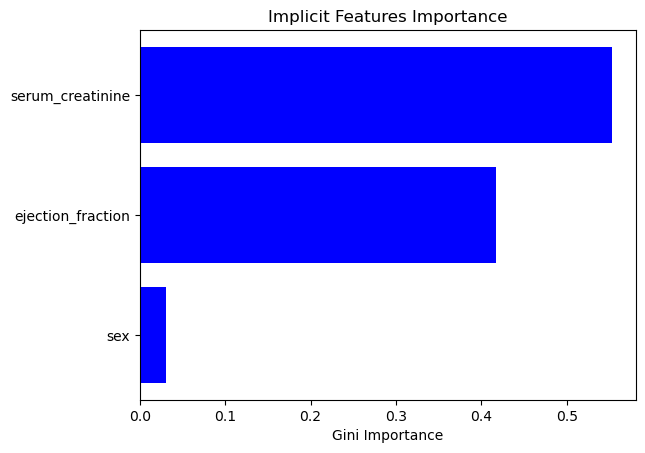

In [12]:
###################################################################################################################
##Step 7 Implicit feature importance
#####################################################

importances = rf_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Implicit Features Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_selected_rf[i] for i in indices])
plt.xlabel('Gini Importance')
plt.show()


In [14]:
import eli5
from eli5 import show_weights
eli5.explain_weights(rf_clf, feature_names=features_selected_rf)


Weight,Feature
0.5531 ± 0.1573,serum_creatinine
0.4166 ± 0.1440,ejection_fraction
0.0303 ± 0.0665,sex


In [16]:
feat_imp_df = eli5.explain_weights_df(rf_clf, feature_names=features_selected_rf)
feat_imp_df

,feature,weight,std
0,serum_creatinine,0.553084,0.078659
1,ejection_fraction,0.416591,0.071983
2,sex,0.030325,0.033273


In [17]:
result = feat_imp_df.sort_values(['weight'], ascending=False, ignore_index=True)
result

,feature,weight,std
0,serum_creatinine,0.553084,0.078659
1,ejection_fraction,0.416591,0.071983
2,sex,0.030325,0.033273


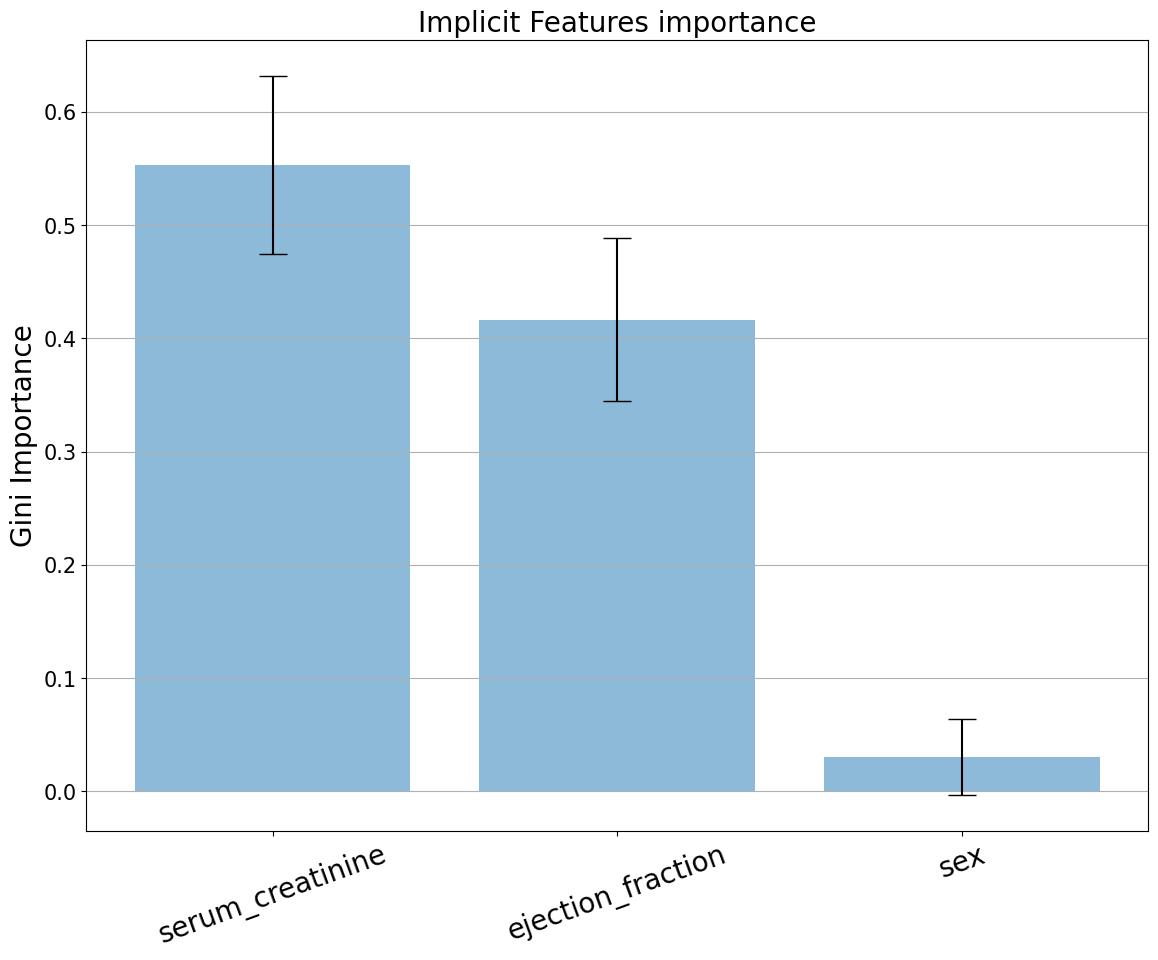

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(result['feature'], result['weight'], yerr=result['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Gini Importance', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(result['feature'])
ax.set_xticklabels(result['feature'], fontsize=20,rotation=20 )
ax.set_title('Implicit Features importance', fontsize=20)
ax.yaxis.grid(True)

In [ ]:
# Implicit feature importance for local explainability
###############################################################

y_pred = extratree_clf.predict(df_X_test_featsel)
print('y_pred',y_pred)
print('y_test',y_test)

In [ ]:
y_pred_train = extratree_clf.predict(df_X_train_featsel)
print('y_pred_train',y_pred_train)
print('y_train',y_train)



In [ ]:
#predicting true negative - the patient IS ALIVE
index_TN = 0
print(df_X_test_featsel.iloc[index_TN])
print(X_test_feat_sel.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])
eli5.explain_prediction(extratree_clf,df_X_test_featsel.iloc[index_TN], feature_names=features_selected_xtree)



In [ ]:
#predicting true postive - the patient IS DEAD
index_TP = 2
print(df_X_test_featsel.iloc[index_TP])
print(X_test_feat_sel.iloc[index_TP])
print('Actual Label:', y_test[index_TP])
print('Predicted Label:', y_pred[index_TP])
eli5.explain_prediction(extratree_clf,df_X_test_featsel.iloc[index_TP], feature_names=features_selected_xtree)


In [ ]:
#predicting true negative - the patient IS ALIVE - FOR TRAINING INSTANCE
index_TN_train = 1
print(df_X_train_featsel.iloc[index_TN_train])
print(X_train_feat_sel.iloc[index_TN_train])
print('Actual Label:', y_train[index_TN_train])
print('Predicted Label:', y_pred_train[index_TN_train])
eli5.explain_prediction(extratree_clf,df_X_train_featsel.iloc[index_TN_train], feature_names=features_selected_xtree)


In [ ]:
#predicting true negative - the patient IS ALIVE - FOR TRAINING INSTANCE
index_TP_train = 7
print(df_X_train_featsel.iloc[index_TP_train])
print(X_train_feat_sel.iloc[index_TP_train])
print('Actual Label:', y_train[index_TP_train])
print('Predicted Label:', y_pred_train[index_TP_train])
eli5.explain_prediction(extratree_clf,df_X_train_featsel.iloc[index_TP_train], feature_names=features_selected_xtree)

###################################################################################################################
##Step 8 Feature permutation importance
#############################################################

In [19]:
# With X_train
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(rf_clf).fit(df_X_train_featsel,y_train)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_rf)
feat_perm_df


,feature,weight,std
0,serum_creatinine,0.247847,0.026277
1,ejection_fraction,0.194258,0.016464
2,sex,0.044976,0.010307


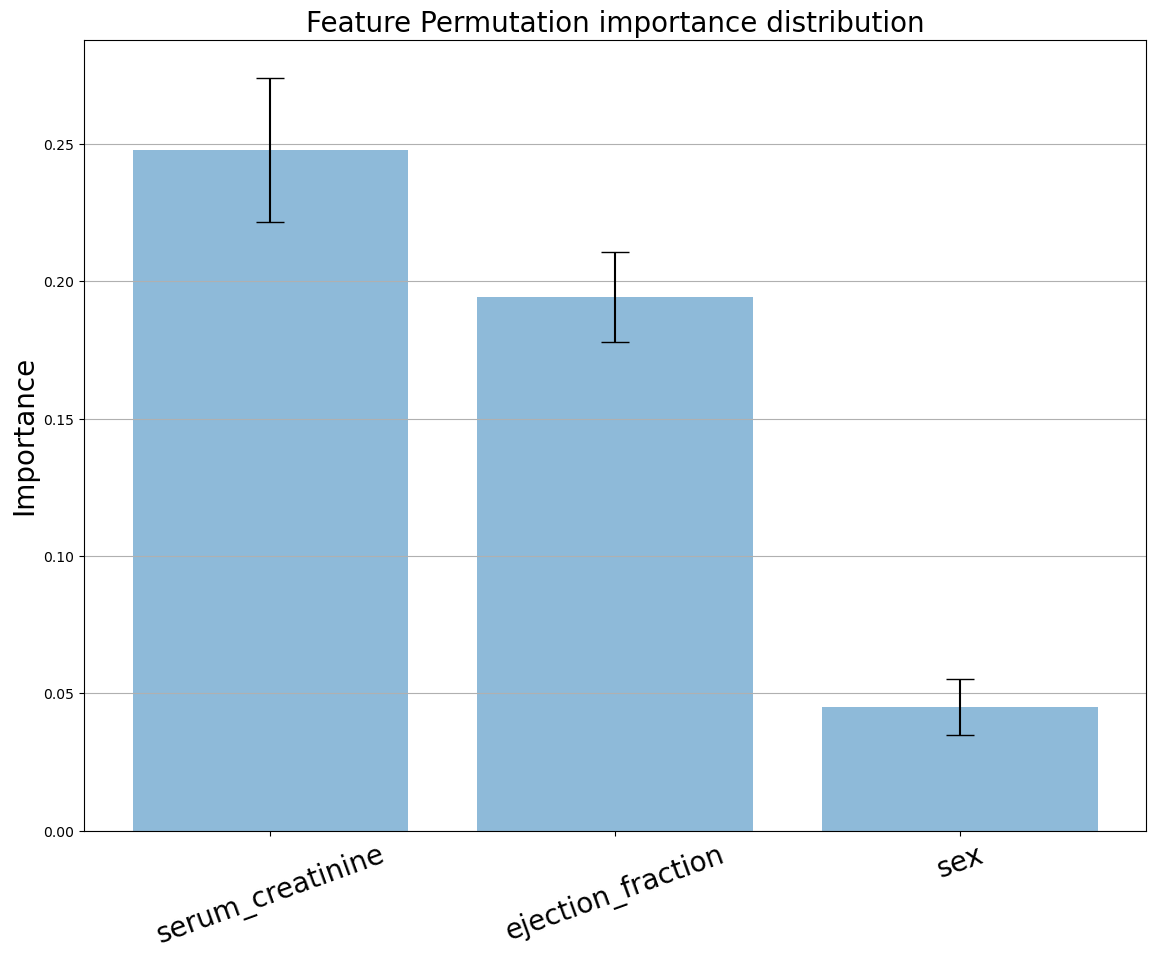

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance', fontsize=20)
ax.set_xticks(feat_perm_df['feature'])
ax.set_xticklabels(feat_perm_df['feature'], fontsize=20,rotation=20 )
ax.set_title('Feature Permutation importance distribution', fontsize=20)
ax.yaxis.grid(True)

In [ ]:
# With X_test
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(extratree_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xtree)
feat_perm_df


In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(feat_perm_df['feature'])
ax.set_xticklabels(feat_perm_df['feature'], fontsize=20,rotation=20)
ax.set_title('Feature Permutation importance distribution', fontsize=20)
ax.yaxis.grid(True)


In [31]:
###################################################################################################################
##Step 9 PDP plots
#############################################################

from pdpbox import pdp,  info_plots
pipe_pdp_xtree=Pipeline([('data_prep',dataprep_merge_feat_xtree),
                          ('clf', rf_clf)])

model=pipe_pdp_xtree.fit(X_train_feat_sel,y_train)



 Tue Jul  4 23:49:22 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Tue Jul  4 23:49:22 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Tue Jul  4 23:49:22 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Tue Jul  4 23:49:22 2023 >>>>>>>>Calling init() from Category_Imputer

 Tue Jul  4 23:49:22 2023 >>>>>>>>Calling fit() from Category_Imputer

 Tue Jul  4 23:49:22 2023 >>>>>>>>Calling transform() from Category_Imputer


In [33]:
pdp

<module 'pdpbox.pdp' from 'c:\\Users\\xdpemo\\AppData\\Local\\anaconda3\\envs\\XAI\\lib\\site-packages\\pdpbox\\pdp.py'>


 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Category_Imputer

 Wed Jul  5 00:12:35 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Wed 

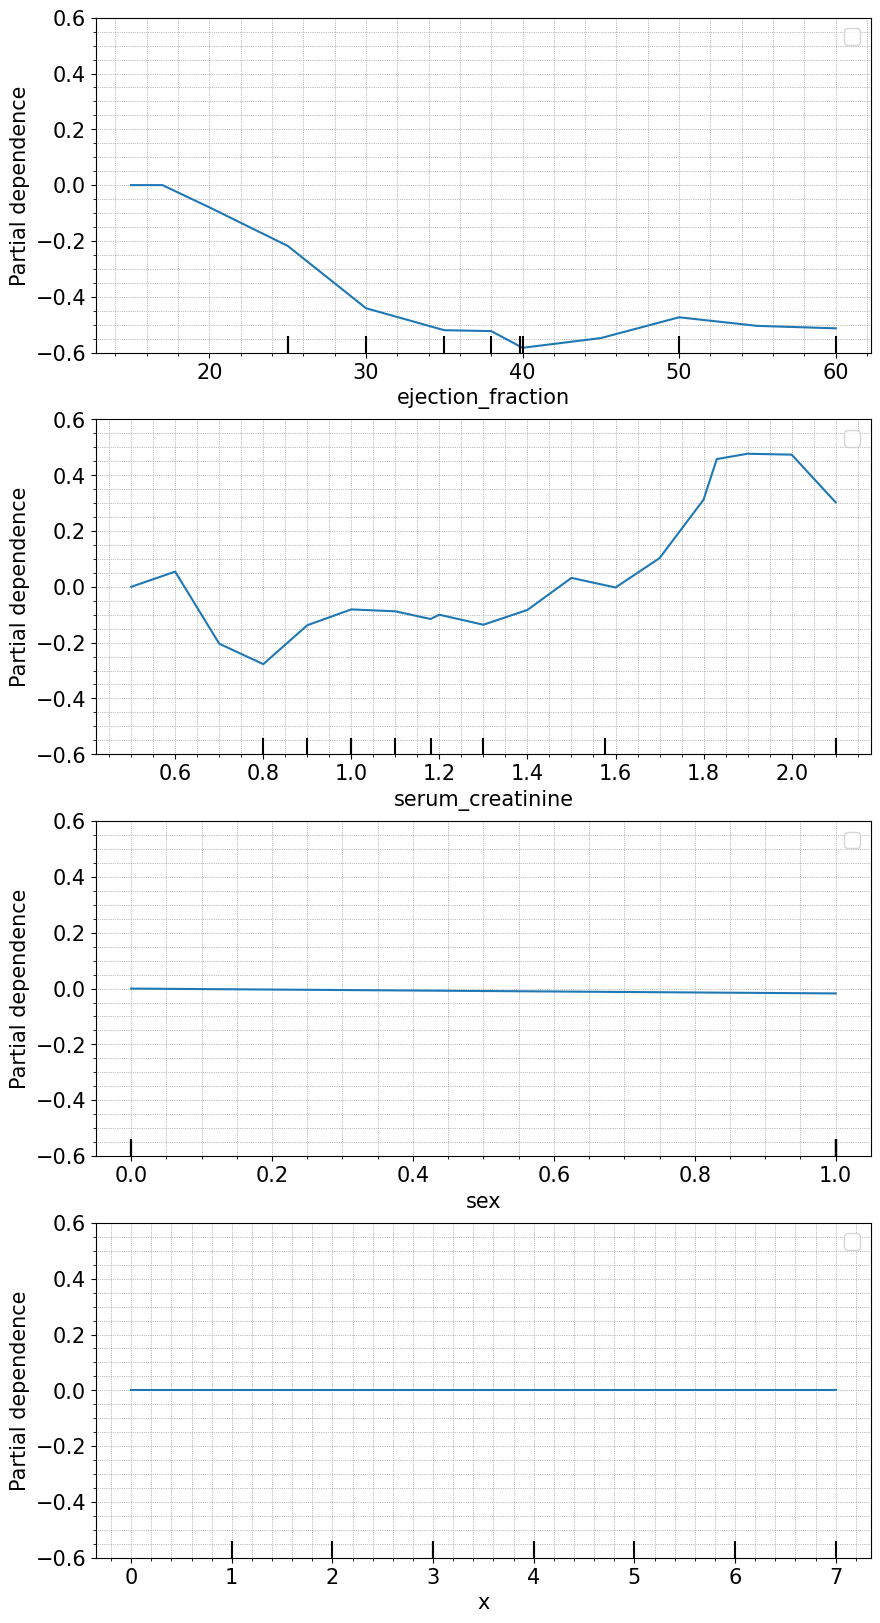

In [53]:
from sklearn.inspection import PartialDependenceDisplay
fig_train, (ax1, ax2, ax3,ax4) = plt.subplots(4, 1, figsize=(10, 20))
def custom_axis(axis):
    axis.yaxis.grid(True)
    axis.xaxis.grid(True)
    axis.set_ylim(-0.6,0.6)
    # axis.grid(which='major', color='#DDDDDD', linewidth=0.8)
    # axis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    #axis.grid(which='major', color='k', linestyle=':', linewidth=0.5)
    axis.grid(visible=True, which='both', axis='both', color='grey', linestyle=':', linewidth=0.5)
    #axis.grid(visible=True, which='minor', color='grey', linestyle=':', linewidth=0.5)
    axis.minorticks_on()
    axis.tick_params(axis='both', labelsize=15)
    axis.xaxis.label.set_fontsize(15)
    axis.yaxis.label.set_fontsize(15)
    axis.legend(fontsize=15)
PartialDependenceDisplay.from_estimator(model, X_train_feat_sel, X_train_feat_sel.columns,ax=[ax1, ax2, ax3,ax4], target=0, centered=True)
custom_axis(fig_train.axes[0])
custom_axis(fig_train.axes[1])
custom_axis(fig_train.axes[2])
custom_axis(fig_train.axes[3])

In [34]:
pdp_age_Xtrain= pdp.PDPIsolate(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, feature='serum_creatinine')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'serum_creatinine',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=-1, ymax=1)
axes['pdp_ax']['_pdp_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].set_xlabel('serum_creatinine', fontsize=20)
axes['pdp_ax']['_count_ax'].set_title('distribution of data points', fontsize=13)


TypeError: PDPIsolate.__init__() got an unexpected keyword argument 'dataset'

In [45]:
pdp_age_Xtrain= pdp.PDPIsolate(model=model, df=X_train_feat_sel, model_features=X_train_feat_sel.columns, feature='serum_creatinine', feature_name='serum_creatinine')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'serum_creatinine',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=-1, ymax=1)
axes['pdp_ax']['_pdp_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].set_xlabel('serum_creatinine', fontsize=20)
axes['pdp_ax']['_count_ax'].set_title('distribution of data points', fontsize=13)

AssertionError: n_classes is required when it can't be accessed through model.n_classes_.

In [30]:
pdp_age_Xtrain= pdp.pdp_isolate(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, feature='ejection_fraction')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'ejection_fraction',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=-1, ymax=1)
axes['pdp_ax']['_pdp_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].set_xlabel('ejection_fraction', fontsize=20)
axes['pdp_ax']['_count_ax'].set_title('distribution of data points', fontsize=13)

AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_isolate'

In [ ]:
pdp_age_Xtrain= pdp.pdp_isolate(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, feature='sex')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'diabetes',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=-1, ymax=1)
axes['pdp_ax']['_pdp_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].tick_params(axis='both', labelsize=15)
axes['pdp_ax']['_count_ax'].set_xlabel('diabetes', fontsize=20)
axes['pdp_ax']['_count_ax'].set_title('distribution of data points', fontsize=13)


In [32]:
###################################################################################################################
## Step 10 2D partial dependece plots
##############################################################

feat_comb3=['ejection_fraction','serum_creatinine']

comb3=pdp.pdp_interact(model=model, dataset=X_train_feat_sel, model_features=X_train_feat_sel.columns, features=feat_comb3)


AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_interact'

In [ ]:
pdp.pdp_interact_plot(pdp_interact_out=comb1, feature_names=feat_comb1, plot_type='contour', x_quantile=True, plot_pdp=True)
plt.show()


In [ ]:
fig, axes, summary_df = info_plots.actual_plot_interact(model=model, X=X_train_feat_sel, features=feat_comb1, feature_names=feat_comb1)


In [ ]:
#Ploting ['time','serum_creatinine']
pdp.pdp_interact_plot(pdp_interact_out=comb2, feature_names=feat_comb2, plot_type='contour', x_quantile=True, plot_pdp=True)
plt.show()


In [ ]:
fig, axes, summary_df = info_plots.actual_plot_interact(model=model, X=X_train_feat_sel, features=feat_comb2, feature_names=feat_comb2)


In [ ]:
#Ploting ['ejection_fraction','serum_creatinine'']
pdp.pdp_interact_plot(pdp_interact_out=comb3, feature_names=feat_comb3, plot_type='contour', x_quantile=True, plot_pdp=True)
plt.show()


In [ ]:
fig, axes, summary_df = info_plots.actual_plot_interact(model=model, X=X_train_feat_sel, features=feat_comb3, feature_names=feat_comb3)

In [ ]:
###################################################################################################################
## Step 11 SHAP explainability 
##############################################################

#global explainability
##################################################################
import shap
shap.initjs()

pipe_shap_xtree=Pipeline([('data_prep',dataprep_merge_feat_xtree),
                          ('clf', extratree_clf)])
pipe_shap_xtree.fit(X_train_feat_sel, y_train)

explainer=shap.explainers.Tree(pipe_shap_xtree.named_steps['clf'], pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_train_feat_sel))
shap_values=explainer.shap_values(pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_train_feat_sel))


In [ ]:
np.shape(shap_values)


In [ ]:
shap.summary_plot(shap_values, X_train_feat_sel,plot_type="bar")

In [ ]:
shap.summary_plot(shap_values[0], X_train_feat_sel,plot_type="dot")

In [ ]:
shap.summary_plot(shap_values[1], X_train_feat_sel,plot_type="dot")


In [ ]:
X_train_feat_sel.head()


In [ ]:
#local explainability
##########################################################
explainer=shap.explainers.Tree(pipe_shap_xtree.named_steps['clf'], pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_test_feat_sel))
shap_values=explainer.shap_values(pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_test_feat_sel))


In [ ]:
np.shape(shap_values)

In [ ]:
#True negative instance
index_TN_shap=5
print(X_test_feat_sel.iloc[index_TN_shap])
print('Actual Label:', y_test[index_TN_shap])
print('Predicted Label:', y_pred[index_TN_shap])
choosen_instance_tn=X_test_feat_sel.iloc[index_TN_shap]


In [ ]:
shap_values_tn = explainer.shap_values(choosen_instance_tn)
shap.force_plot(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)


In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)


In [ ]:
index_TP_shap=2
print(X_test_feat_sel.iloc[index_TP_shap])
print('Actual Label:', y_test[index_TP_shap])
print('Predicted Label:', y_pred[index_TP_shap])
choosen_instance_tp=X_test_feat_sel.iloc[index_TP_shap]


In [ ]:
shap_values_tp = explainer.shap_values(choosen_instance_tp)
shap.force_plot(explainer.expected_value[1], shap_values_tp[1], choosen_instance_tp)
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values_tp[1], choosen_instance_tp)


In [ ]:
index_TN_shap_train = 1
print(df_X_train_featsel.iloc[index_TN_shap_train])
print(X_train_feat_sel.iloc[index_TN_shap_train])
print('Actual Label:', y_train[index_TN_shap_train])
print('Predicted Label:', y_pred_train[index_TN_shap_train])
choosen_instance_tn_train=X_train_feat_sel.iloc[index_TN_shap_train]

In [ ]:
shap_values_tn_train = explainer.shap_values(choosen_instance_tn_train)
shap.force_plot(explainer.expected_value[0], shap_values_tn_train[0], choosen_instance_tn_train)

In [ ]:
shap_values_tn_train

In [ ]:
index_TP_shap_train = 7
print(df_X_train_featsel.iloc[index_TP_shap_train])
print(X_train_feat_sel.iloc[index_TP_shap_train])
print('Actual Label:', y_train[index_TP_shap_train])
print('Predicted Label:', y_pred_train[index_TP_shap_train])
choosen_instance_tp_train=X_train_feat_sel.iloc[index_TP_shap_train]

In [ ]:
shap_values_tp_train = explainer.shap_values(choosen_instance_tp_train)
shap.force_plot(explainer.expected_value[1], shap_values_tp_train[1], choosen_instance_tp_train)

In [ ]:
###################################################################################################################
## Step 12 LIME
##############################################################
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train_feat_sel), feature_names=np.array(X_train_feat_sel.columns), class_names=np.array([0, 1]), mode="classification",discretize_continuous=False)


In [ ]:
index=0
exp = explainer.explain_instance(X_train_feat_sel.iloc[index,:].values, pipe_shap_xtree.named_steps['clf'].predict_proba, num_features=5)

In [ ]:
exp.show_in_notebook(show_table = True, show_all= False)
